In [1]:
#================1.retrieve data===========================
import sys
import os
import urllib.request
import getpass
import requests

def verify_datasize(filename, expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found and verified.", filename)
    else:
        raise Exception("Failed to veryfile file [{}], file_size [{}], expected_size [{}].".format(filename, statinfo.st_size, expected_bytes))

        
#Reports every 5% change in download progress
last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100) / totalSize
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
        else:
            sys.stdout.write(".")
        sys.stdout.flush()
    last_percent_reported = percent

    
#download a file from url and check size
data_root = "." #data saved local directory

urls = [['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip', 569918665],
      ['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip',284478493]]
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

def download_data_without_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        urllib.request.urlretrieve(url, dest_filename, download_progress_hook)
        print("\nDownload completed!")
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename

#first you must login to Kaggle, direct to the specific competition, and accept rules competition, or post will direct to rules page.
#eg:dogs-vs-cats's rule page is:https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules
def download_data_with_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        user_name = input("Enter username:")
        pwd = getpass.getpass("Enter password:")
        authen_info = {'UserName':user_name, 'Password': pwd}
        
        #To go to the redirect url
        resp = requests.get(url, headers=headers)
        print("Redirected:", resp.url)

        #To login and get data
        resp = requests.post(resp.url, data = authen_info, headers=headers,stream=True)
        print("Redirected:", resp.url)
        print("Status:", resp.status_code)
        
        if resp.status_code == requests.codes.ok:
            f = open(dest_filename, 'wb')
            for chunk in resp.iter_content(chunk_size = 512 * 1024):# Reads 512KB at a time into memory
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
            f.close()
            print("\nDownload completed!")
        else:
            raise Exception("\nDownload failed")
        
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename
   

train_filename = download_data_with_Authentication(urls[0][0], urls[0][1])
test_filename = download_data_with_Authentication(urls[1][0], urls[1][1])            

Found and verified. ./train.zip
Found and verified. ./test.zip


In [2]:
#=================2.unzip file and explore image files======================
import zipfile

def unzip_file(filename):
    file_to_unzip = zipfile.ZipFile(filename)
    file_to_unzip.extractall()
    file_to_unzip.close()
    print("Unzip file succeed.", filename)
    
unzip_file(train_filename)
unzip_file(test_filename)
    

Unzip file succeed. ./train.zip
Unzip file succeed. ./test.zip


In [6]:
import os
import shutil
from PIL import Image

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

def rebuild_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
        
def rearrange_data(category_name):
    if category_name not in categories:
        raise Exception("\n category [{}] not exists.", category_name)
        
    category_data_dir = cate_dat_dir + "/" + category_name
    rebuild_dir(category_data_dir)
    
    train_filenames = os.listdir('./train')
    train_category = filter(lambda x:x[:3].upper() ==category_name.upper() , train_filenames)
    train_count = 0
    for filename in train_category:
        train_count += 1
        shutil.copy("./train/" + filename, category_data_dir)
    return train_count
 
def get_image_properties(category_name):
    if category_name not in categories:
        raise Exception("\n category {{}] not exists.", category_name)
        
    category_map = {}
    path = cate_dat_dir + "/" + category_name + "/"
    filenames = os.listdir(path)
    for filename in filenames:
        im = Image.open(path + filename)
        category_map[filename] = [im.format, im.mode, im.width, im.height]
    return category_map
'''
rebuild_dir(dat_dir)
rebuild_dir(cate_dat_dir)
dog_counts = rearrange_data("dog")
cat_counts = rearrange_data("cat")
image_properties_dog = get_image_properties("dog")
image_properties_cat = get_image_properties("cat")
'''

'\nrebuild_dir(dat_dir)\nrebuild_dir(cate_dat_dir)\ndog_counts = rearrange_data("dog")\ncat_counts = rearrange_data("cat")\nimage_properties_dog = get_image_properties("dog")\nimage_properties_cat = get_image_properties("cat")\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

columns = ['format', 'mode', 'width', 'height']

df_dog = pd.DataFrame(image_properties_dog).transpose()
df_cat = pd.DataFrame(image_properties_cat).transpose()
df_dog.columns = columns
df_cat.columns = columns

print("\ndogs count : [{}]. cats count:[{}]".format(dog_counts, cat_counts))

print("\ndogs group by format, mode:")
print(df_dog.groupby(['format', 'mode'])['width'].count())
print("\ncats group by format, mode:")
print(df_cat.groupby(['format', 'mode'])['width'].count())


plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.scatter(x=df_dog['width'], y=df_dog['height'], s=10, marker=".", color='red')
plt.scatter(x=df_cat['width'], y=df_cat['height'], s=10, marker="*", color='blue')
plt.legend(['dogs','cats'], loc='center right')
plt.xlabel('widht')
plt.ylabel('height')
plt.title("image size")
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,2)
plt.boxplot([df_dog['width'], df_dog['height'], df_cat['width'], df_cat['height']], showmeans=True)
plt.xticks([1,2,3,4], ['dog-width', 'dog-height', 'cat-width', 'cat-height'])
#plt.subplots_adjust(hspace = .5)
plt.show()

print("\ndogs width max/min:\n",df_dog.loc[[df_dog['width'].idxmax(),df_dog['width'].idxmin()]])
print("\ndogs height max/min:\n",df_dog.loc[[df_dog['height'].idxmax(),df_dog['height'].idxmin()]])
print("\ncats width max/mai:\n",df_cat.loc[[df_cat['width'].idxmax(),df_cat['width'].idxmin()]])
print("\ncats height max/min:\n",df_cat.loc[[df_cat['height'].idxmax(),df_cat['height'].idxmin()]])

NameError: name 'image_properties_dog' is not defined

In [8]:
#========================3.split and preprocess data================================
import random

def split_train_valid(category_name, test_percent, random_seed=None, create_link=False):
    if category_name not in categories:
        raise Exception("\n category [{}] note exists.", category_name)
    if test_percent <=0 or test_percent >=1:
        raise Exception("\n test_percent must be in (0,1)")
        
    source_dir = cate_dat_dir + "/" + category_name + "/"
    dest_train_dir = train_dat_dir + "/" + category_name + "/"
    dest_valid_dir = valid_dat_dir + "/" + category_name + "/"
    
    filenames = os.listdir(source_dir)
    total_size = len(filenames)
    test_size = int(total_size * test_percent)
    train_size = total_size - test_size
    
    if not random_seed is None:
        random.seed(random_seed)
    random.shuffle(filenames)
    rebuild_dir(dest_train_dir)
    rebuild_dir(dest_valid_dir)
    for i in range(0, total_size):
        if i < test_size:
            dest_dir = dest_valid_dir
        else:
            dest_dir = dest_train_dir
        
        if create_link == True:
                os.symlink(source_dir + filenames[i], dest_dir + filenames[i])
        else:
                shutil.copy(source_dir + filenames[i], dest_dir)
                
    return train_size, test_size


In [ ]:
#model_vgg19
import ModelUtil
import importlib
importlib.reload(ModelUtil)

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 128
poch_num = 20

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

name_vgg19 = "model_vgg19"
model_vgg19 = ModelUtil.model_vgg19(image_width, image_height)
model_vgg19.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg19, model_name=name_vgg19)
history_vgg19 = ModelUtil.train_data(model_vgg19, model_name=name_vgg19, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg19, model_name=name_vgg19)
ModelUtil.predict_data(model_vgg19, model_name=name_vgg19, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_vgg19, model_name=name_vgg19)

Using TensorFlow backend.


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/20


In [8]:
#model_vgg16
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 32
poch_num = 40


name_vgg16 = "model_vgg16"
model_vgg16 = ModelUtil.model_vgg16(image_width, image_height)
#model_vgg16.add(Dense(256, activation='relu', name='denseout1'))
#model_vgg16.add(Dense(64, activation='relu', name='denseout2'))
model_vgg16.add(Dense(1, activation='relu', name='denseout3'))
rmsp = optimizers.RMSprop(lr=0.001)
model_vgg16.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16, model_name=name_vgg16)
history_vgg16 = ModelUtil.train_data(model_vgg16, model_name=name_vgg16, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16, model_name=name_vgg16)
ModelUtil.predict_data(model_vgg16, model_name=name_vgg16, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_vgg16, model_name=name_vgg16)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/40


ResourceExhaustedError: OOM when allocating tensor with shape[4096,4096]
	 [[Node: mul_538 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_166/read, gradients_5/MatMul_28_grad/MatMul_1)]]

Caused by op 'mul_538', defined at:
  File "/opt/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-be8d18284aa9>", line 34, in <module>
    valid_dir=valid_dat_dir, valid_size=total_valid_size)
  File "/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py", line 167, in train_data
    callbacks=[TensorBoard(log_dir=log_location)])
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/models.py", line 907, in fit_generator
    pickle_safe=pickle_safe)
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 1351, in fit_generator
    self._make_train_function()
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 696, in _make_train_function
    self.total_loss)
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/optimizers.py", line 215, in get_updates
    new_p = p - lr * g / (K.sqrt(new_a) + self.epsilon)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 620, in _run_op
    return getattr(ops.Tensor, operator)(a._AsTensor(), *args)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 751, in binary_op_wrapper
    return func(x, y, name=name)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 910, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1519, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[4096,4096]
	 [[Node: mul_538 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_166/read, gradients_5/MatMul_28_grad/MatMul_1)]]


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/80
17500/17500 [==============================] - 167s - loss: 0.6713 - acc: 0.5694 - val_loss: 0.6432 - val_acc: 0.6191
Epoch 2/80
17500/17500 [==============================] - 162s - loss: 0.6364 - acc: 0.6278 - val_loss: 0.6170 - val_acc: 0.6553
Epoch 3/80
17500/17500 [==============================] - 162s - loss: 0.6071 - acc: 0.6624 - val_loss: 0.5748 - val_acc: 0.6959
Epoch 4/80
17500/17500 [==============================] - 165s - loss: 0.5737 - acc: 0.6923 - val_loss: 0.5553 - val_acc: 0.7073
Epoch 5/80
17500/17500 [==============================] - 161s - loss: 0.5545 - acc: 0.7101 - val_loss: 0.7397 - val_acc: 0.6108
Epoch 6/80
17500/17500 [==============================] - 161s - loss: 0.5360 - acc: 0.7242 - val_loss: 0.5172 - val_acc: 0.7371
Epoch 7/80
17500/17500 [==============================] - 161s - loss: 0.5151 - acc: 0.7395 - val_loss: 0.4873 - val_acc: 0.7643
Epoch 8/80
1

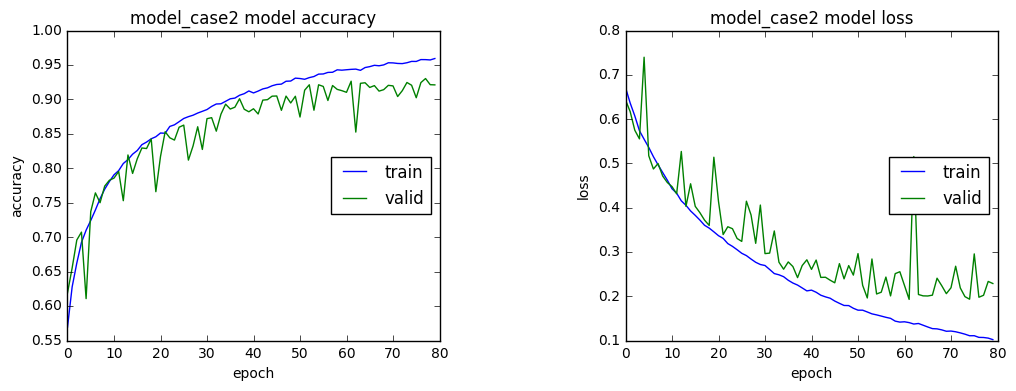

In [6]:
#model_case2
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 80


name_case2 = "model_case2"
model_case2 = ModelUtil.model_mycase2(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.0001)
model_case2.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2, model_name=name_case2)
history_case2 = ModelUtil.train_data(model_case2, model_name=name_case2, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2, model_name=name_case2)
#ModelUtil.predict_data(model_case2, model_name=name_case2, 
#                 image_size=(image_width, image_height), 
#                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2, model_name=name_case2)

/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu", name="block1_cov1", input_shape=(150, 150,...)`
  model.add(Convolution2D(16, 3, 3, input_shape=(image_width, image_height,3), activation='relu', border_mode='same', name='block1_cov1'))
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:131: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same", name="block1_pool1")`
  model.add(MaxPooling2D((2,2), border_mode='same', name='block1_pool1'))
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:133: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", name="block2_cov1", kernel_regularizer=<keras.reg...)`
  model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', name='block2_cov1', kernel_regularizer=regularize

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:200: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  callbacks=[TensorBoard(log_dir=log_location)])
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:200: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=274, validation_steps=118, epochs=70, callbacks=[<keras.ca..., validation_data=<keras.pre...)`
  callbacks=[TensorBoard(log_dir=log_location)])


Epoch 1/70
274/274 [==============================] - 160s - loss: 0.7414 - acc: 0.5710 - val_loss: 0.6763 - val_acc: 0.6005
Epoch 2/70
274/274 [==============================] - 156s - loss: 0.6130 - acc: 0.6784 - val_loss: 0.5456 - val_acc: 0.7336
Epoch 3/70
274/274 [==============================] - 156s - loss: 0.5189 - acc: 0.7572 - val_loss: 0.4658 - val_acc: 0.7889
Epoch 4/70
274/274 [==============================] - 155s - loss: 0.4626 - acc: 0.7918 - val_loss: 0.4249 - val_acc: 0.8157
Epoch 5/70
274/274 [==============================] - 155s - loss: 0.4216 - acc: 0.8142 - val_loss: 0.4018 - val_acc: 0.8268
Epoch 6/70
274/274 [==============================] - 155s - loss: 0.3852 - acc: 0.8366 - val_loss: 0.3731 - val_acc: 0.8437
Epoch 7/70
274/274 [==============================] - 155s - loss: 0.3559 - acc: 0.8536 - val_loss: 0.3331 - val_acc: 0.8621
Epoch 8/70
274/274 [==============================] - 156s - loss: 0.3316 - acc: 0.8624 - val_loss: 0.3568 - val_acc: 0.8508


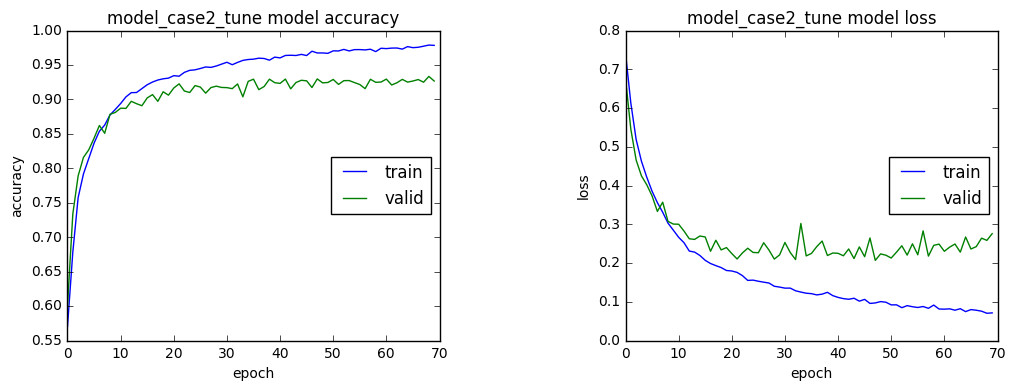

In [4]:
#model_case2_tune
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 70


name_case2_tune = "model_case2_tune"
model_case2_tune = ModelUtil.model_mycase2_tune(image_width, image_height)
adam = optimizers.Adam(lr=0.0005)
#rmsp = optimizers.RMSprop(lr=0.0001)
model_case2_tune.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune, model_name=name_case2_tune)
history_case2_tune = ModelUtil.train_data(model_case2_tune, model_name=name_case2_tune, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                         train_dir=train_dat_dir, train_size=total_train_size,
                         valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2_tune, model_name=name_case2_tune)
#ModelUtil.predict_data(model_case2_tune, model_name=name_case2_tune, 
#                 image_size=(image_width, image_height), 
#                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2_tune, model_name=name_case2_tune)

In [9]:
#model_case2_tune
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train1"
valid_dat_dir = dat_dir + "/valid1"
categories = ["cat", "dog"]
rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.2, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.2, 1234, False)

total_train_size = 20000 #dog_train_size + cat_train_size
total_valid_size = 5000 #dog_test_size + cat_test_size
image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 30

name_case2_tune1 = "model_case2_tune1"
model_case2_tune1 = ModelUtil.model_mycase2_tune(image_width, image_height)
adam = optimizers.Adam(lr=0.0005)
#rmsp = optimizers.RMSprop(lr=0.0001)
model_case2_tune1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune1, model_name=name_case2_tune1)
history_case2_tune = ModelUtil.train_data(model_case2_tune1, model_name=name_case2_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                         train_dir=train_dat_dir, train_size=total_train_size,
                         valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(model_case2_tune1, model_name=name_case2_tune1)
#ModelUtil.predict_data(model_case2_tune1, model_name=name_case2_tune1, 
#                 image_size=(image_width, image_height), 
#                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2_tune1, model_name=name_case2_tune1)

/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu", name="block1_cov1", input_shape=(150, 150,...)`
  model.add(Convolution2D(16, 3, 3, input_shape=(image_width, image_height,3), activation='relu', border_mode='same', name='block1_cov1'))
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:131: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same", name="block1_pool1")`
  model.add(MaxPooling2D((2,2), border_mode='same', name='block1_pool1'))
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:133: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", name="block2_cov1", kernel_regularizer=<keras.reg...)`
  model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', name='block2_cov1', kernel_regularizer=regularize

AttributeError: 'str' object has no attribute 'layers'